In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix


/var/folders/lr/_51sy7t10711nvcvm3nr0k7c0000gn/T/ipykernel_2500/1233442144.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [11]:
# Функція для обробки файлів
def process_file(gyroscope_file, accelerometer_file, label):
    # Зчитування та перейменування стовпців гіроскопа
    df_gyro = pd.read_csv(gyroscope_file, index_col=0)
    df_gyro = df_gyro.rename(columns={'z': 'z_gyroscope', 'y': 'y_gyroscope', 'x': 'x_gyroscope'})
    
    # Зчитування та перейменування стовпців акселерометра
    df_acc = pd.read_csv(accelerometer_file, index_col=0)
    df_acc = df_acc.rename(columns={'z': 'z_accelerometer', 'y': 'y_accelerometer', 'x': 'x_accelerometer'})
    df_acc = df_acc.drop(['seconds_elapsed'], axis=1)
    
    # Об'єднання даних гіроскопа та акселерометра
    df_combined = df_gyro.join(df_acc)
    
    # Видалення рядків з пропущеними значеннями
    df_combined.dropna(inplace=True)
    
    # Додавання мітки класу
    df_combined["Class"] = label
    
    return df_combined

# Список файлів гіроскопу та акселерометра
files = [
    ('pres_gyroscope.csv', 'pres_accelerometer.csv', 1),
    ('jack_gyroscope.csv', 'jack_accelerometer.csv', 0),
    ('run_gyroscope.csv', 'run_accelerometer.csv', 2)
]

# Обробка даних для кожного файлу
dfs = []
for gyro_file, acc_file, label in files:
    df = process_file(gyro_file, acc_file, label)
    dfs.append(df)

# Об'єднання всіх даних в один набір
dataset = pd.concat(dfs, ignore_index=True)

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Поділ даних на тренувальну і валідаційну вибірки (70/30%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Нормалізація даних
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)

# Конвертація в NumPy масиви
X_train_np = np.array(X_train_normalized)
X_val_np = np.array(X_val_normalized)
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)

# Встановлення назв стовпців після нормалізації даних
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=dataset.columns[:-1])
X_val_normalized_df = pd.DataFrame(X_val_normalized, columns=dataset.columns[:-1])

# Побудова кореляційної матриці
correlation_matrix = pd.DataFrame(X_train_normalized_df).corr()

# Виведення кореляційної матриці
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Кореляційна матриця')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

# Оголошення моделі
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(DeepNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

input_size = 7  # Кількість ознак у вхідних даних
hidden_size1 = 128  # Розмір першого прихованого шару
hidden_size2 = 64  # Розмір другого прихованого шару
num_classes = 3  # Кількість класів

model = DeepNeuralNetwork(input_size, hidden_size1, hidden_size2, num_classes)

# Визначення функції втрат та оптимізатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Конвертація даних в тензори PyTorch
X_train_tensor = torch.FloatTensor(X_train_np)
y_train_tensor = torch.LongTensor(y_train_np)
X_val_tensor = torch.FloatTensor(X_val_np)
y_val_tensor = torch.LongTensor(y_val_np)

# Навчання моделі
num_epochs = 2500
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass та оптимізація
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Перевірка точності моделі на валідаційних даних
with torch.no_grad():
    outputs = model(X_val_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_val_tensor.numpy(), predicted.numpy())
    print(f'Accuracy on the validation set: {accuracy:.2f}')

# Обчислення матриці конфузії
cm = confusion_matrix(y_val_tensor.numpy(), predicted.numpy())
print("Confusion Matrix:")
print(cm)



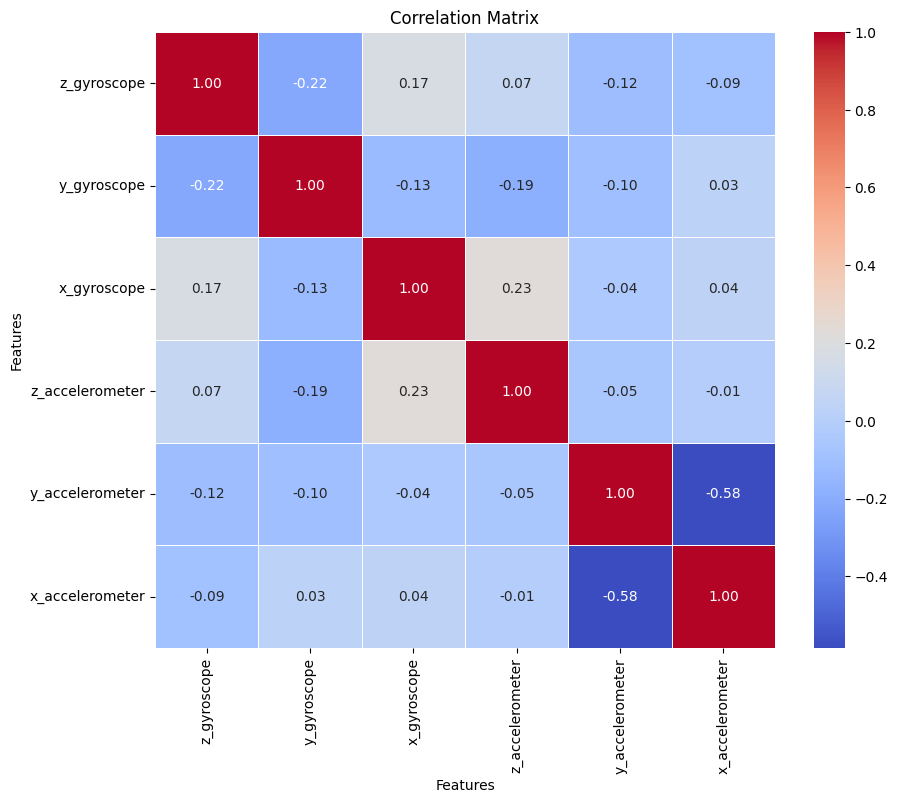

In [12]:

label_encoder = LabelEncoder()
# Обчислення матриці конфузії

class_names = ['Джек', 'Прес', 'Біг']

# Функція для побудови матриці конфузії
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Виклик функції для побудови графічного представлення матриці конфузії
plot_confusion_matrix(cm, class_names)


In [13]:

# Plot the graph
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(dataset.index, dataset['z_accelerometer'], label='z_accelerometer')  # Plot column A
plt.plot(dataset.index, dataset['y_accelerometer'], label='y_accelerometer')  # Plot column B
plt.plot(dataset.index, dataset['x_accelerometer'], label='x_accelerometer')  # Plot column C

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()  # Add legend

# Show plot
plt.grid(True)
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (40430x6 and 7x128)

Підбір гіперпараметрів відбувається через зміну епох num_epochs = х

In [ ]:

# Plot the graph
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(dataset.index, dataset['z_gyroscope'], label='z_gyroscope')  # Plot column A
plt.plot(dataset.index, dataset['y_gyroscope'], label='y_gyroscope')  # Plot column B
plt.plot(dataset.index, dataset['x_gyroscope'], label='x_gyroscope')  # Plot column C

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()  # Add legend

# Show plot
plt.grid(True)
plt.show()

NameError: name 'LabelEncoder' is not defined